In [1]:
import sys, os
import numpy as np
import time
import matplotlib.pyplot as plt
%matplotlib notebook
import tempfile
# this file should be run from {caffe_root}/examples (otherwise change this line)
caffe_root = '/media/hermetico/2TB/frameworks/caffe/' 
this_root = os.path.abspath('.')
googlenet_weights = os.path.join(caffe_root, 'models/bvlc_googlenet/bvlc_googlenet.caffemodel')

# main files for the network
activities_net_desc = {
    'weights': os.path.join(this_root,'models/finetuning-googlenet/reference_activitiesnet.caffemodel'),
    'train_val': os.path.join(this_root,'models/finetuning-googlenet/train_val_learn_all.prototxt'),
    'solver': os.path.join(this_root,'models/finetuning-googlenet/solver.prototxt'), 
    'snapshot' :os.path.join(this_root,'models/finetuning-googlenet/finetune_dailyactivities')
}

sys.path.insert(0, caffe_root + 'python')
import caffe
caffe.set_device(0)
caffe.set_mode_gpu()

/home/hermetico/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Net<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Blob<float> > already registered; second conversion method ignored.
  from ._caffe import Net, SGDSolver, NesterovSolver, AdaGradSolver, \
/media/hermetico/2TB/frameworks/caffe/python/caffe/pycaffe.py:13: RuntimeWarning: to-Python converter for boost::shared_ptr<caffe::Solver<float> > already registered; second conversion metho

Here we load the dataset files and parse the information, the image mean file is also loaded

In [2]:
# dataset stuff
train_dataset_path = os.path.join(caffe_root, 'data/daily_activities/train.txt')
val_dataset_path = os.path.join(caffe_root, 'data/daily_activities/val.txt')

train_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(train_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
train_paths, train_labels = zip(*[(path, int(label)) for path, label in train_dataset])

val_dataset = [ line.split(' ') 
                for line in list(np.loadtxt(val_dataset_path, str, delimiter='\n'))
                if len(line.split(' ')) == 2 # there are some images with wierd paths
               ]
val_paths, val_labels = zip(*[(path, int(label)) for path, label in val_dataset])

# labels
labels_set = os.path.join(caffe_root, 'data/daily_activities/labels.txt')
labels_set = list(np.loadtxt(labels_set, str, delimiter='\n'))


mean_file = os.path.join(caffe_root, 'data/ilsvrc12/imagenet_mean.binaryproto')


num_train_images = len(train_paths)
num_val_images = len(val_paths)
NUM_ACTIVITIES_LABELS = len(labels_set)
print 'Loaded labels:\n', ', '.join(labels_set)
print '\nTraining pictures', num_train_images
print '\nValidation pictures', num_val_images

Loaded labels:
Public transport, driving, walking outdoor, walking indoor, biking, having drinks with somebody, having drinks/meal alone, having meal with somebody, socializing, attending a seminar, meeting, reading, tv, cleaning and chores, working, cooking, shopping, talking, resting, mobile, Plane

Training pictures 13991

Validation pictures 1857


<IPython.core.display.Javascript object>


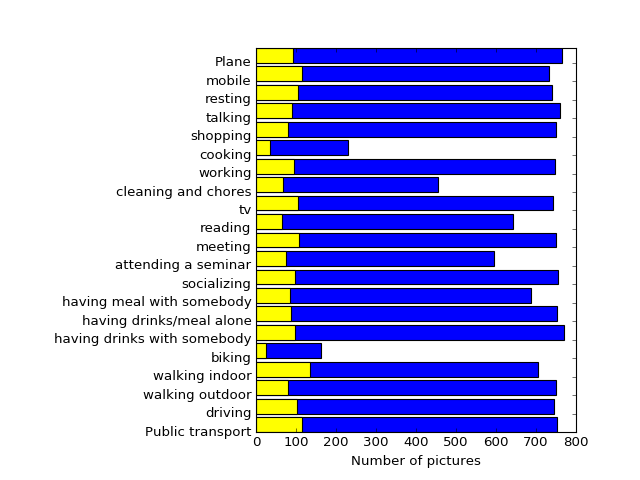

In [5]:
# train an val histogram
def plot_hist( set_labels , title='', color='blue'):
    import matplotlib.pyplot as plt
    plt.gcf().subplots_adjust(left=0.4)
    examples = [0] * NUM_ACTIVITIES_LABELS
    # each index index paths will contain a list of  pictures associated to a category
    for label in set_labels:
        examples[label] += 1

    y_pos = np.arange(NUM_ACTIVITIES_LABELS)
    num_examples = examples
    plt.barh(y_pos, num_examples,  alpha=1, color=color)
    plt.yticks(y_pos, labels_set)

    plt.xlabel('Number of pictures')
    #plt.title('List of categories and number of pictures for validation and training')
    plt.show()
    
plot_hist(train_labels, 'Training')
plot_hist(val_labels, 'val', color='yellow')

In [6]:
def store_weights(weights):
    data = open(weights).read()
    with open(activities_net_desc['weights'], 'w') as f:
        f.write(data)
        
def store_solver(solver):
    with open(activities_net_desc['solver'], 'w') as f:
        f.write(solver)

Here we are going to define the solver file, as caffe does not allow us to define the num of epochs we want to train, we are going to define the number of iterations based on the number of epochs we want

In [7]:
# We are going to train 10 epochs, which means that we are going to go through our dataset 20 times
num_train = num_train_images
num_val = num_val_images
num_epochs = 10
# batch size 32 takes around 4GB 
# if the model doesn't fit in GPU memory, try to reduce the batch size to 24. 
# that needs to be changed in train_val.prototxt too
batch_size = 32 
iters_per_epoch = num_train_images / batch_size # iterations for an epoch
iters_per_val = num_val_images / batch_size


### solver data definition

solver_data = {}
solver_data['val_iter'] = iters_per_val  /  5              # num of iterations for the validation
solver_data['val_interval'] = iters_per_epoch / 4      # we are going to validate twice per epoch
solver_data['base_lr'] = 0.000037                         # initial learning rate
solver_data['display_interval'] = solver_data['val_interval'] / 4
solver_data['num_iter'] = num_epochs * iters_per_epoch # total iterations
solver_data['drop_rate'] = 0.1
solver_data['drop_lr_step'] = 5 * iters_per_epoch      # The learning rate will decrease each 5 epochs
solver_data['train_val'] = activities_net_desc['train_val']
solver_data['snapshot_prefix'] = activities_net_desc['snapshot']
solver_data['snapshot'] = 5 * iters_per_epoch
    

#### SOLVER DEFINITION
solver_content = """test_iter: %(val_iter)i
test_interval: %(val_interval)i
base_lr: %(base_lr).6f
display: %(display_interval)i
max_iter: %(num_iter)i
lr_policy: "step"
gamma: %(drop_rate).5f
momentum: 0.9
weight_decay: 0.005
stepsize: %(drop_lr_step)i
snapshot: %(snapshot)i
snapshot_prefix: "%(snapshot_prefix)s"
solver_mode: GPU
net: "%(train_val)s"
solver_type: SGD""" % (solver_data)

store_solver(solver_content)

print "This is the solver that is going to be used:"
print solver_content

This is the solver that is going to be used:
test_iter: 11
test_interval: 109
base_lr: 0.000037
display: 27
max_iter: 4370
lr_policy: "step"
gamma: 0.10000
momentum: 0.9
weight_decay: 0.005
stepsize: 2185
snapshot: 2185
snapshot_prefix: "/media/hermetico/2TB/frameworks/notebooks/TFG/dist/models/finetuning-googlenet/finetune_dailyactivities"
solver_mode: GPU
net: "/media/hermetico/2TB/frameworks/notebooks/TFG/dist/models/finetuning-googlenet/train_val_learn_all.prototxt"
solver_type: SGD


In [8]:
def run_solvers(niter, solver_data, disp_interval, validation_interval):
    # keep track of the data
    name, s = solver_data
    
    train_types = ('loss1/loss1', 'loss2/loss2', 'loss3/loss3')
    val_types = ('loss1/loss1', 'loss1/top-1',  'loss1/top-5',
                 'loss2/loss2', 'loss2/top-1',  'loss2/top-5',
                 'loss3/loss3', 'loss3/top-1',  'loss3/top-5'
                )
    
    train_data = {t:[0] for t in train_types}
    val_data = {t:[0] for t in val_types}
    
    train_iters = [0]
    val_iters = [0]
    
    
    fig, ax1 = plt.subplots(figsize=(10,7))
    ax2 = ax1.twinx()
    ax1.set_xlabel('iteration')
    ax1.set_ylabel('Loss')
    ax2.set_ylabel('Accuracy')
    

    a, = ax1.plot(train_iters, train_data['loss3/loss3'], 'blue', label='train loss 3')
    c, = ax1.plot(val_iters, val_data['loss3/loss3'], 'red', label='val loss 3')
    d, = ax2.plot(val_iters, val_data['loss3/top-1'], 'green', label='val loss 3 Top 1')
    f, = ax2.plot(val_iters, val_data['loss3/top-5'], 'orange', label='val loss 3 Top 5')
    
    plt.legend(handles=[a, c, d, f],bbox_to_anchor=(0., 1.02, 1., .102), loc=3,
           ncol=2, mode="expand", borderaxespad=0.)
    
    
    for iteration in range(niter):
        s.step(1)  
        
        
        if iteration % disp_interval == 0 or iteration % validation_interval == 0 :
            train_iters.append(iteration)
            train_data['loss3/loss3'].append( s.net.blobs['loss3/loss3'].data.copy() )
        
            ax1.plot(train_iters, train_data['loss3/loss3'], 'blue', label='train loss 3')
            
            
            if iteration % validation_interval == 0 : #or iteration == niter - 1: # interval step and last step

                val_iters.append(iteration)
                val_data['loss3/loss3'].append( s.test_nets[0].blobs['loss3/loss3'].data.copy() )
                val_data['loss3/top-1'].append( s.test_nets[0].blobs['loss3/top-1'].data.copy() )
                val_data['loss3/top-5'].append( s.test_nets[0].blobs['loss3/top-5'].data.copy() )

                ax1.plot(val_iters, val_data['loss3/loss3'], 'red', label='val loss 3')
                ax2.plot(val_iters, val_data['loss3/top-1'], 'green', label='val loss 3 Top 1')
                ax2.plot(val_iters, val_data['loss3/top-5'], 'orange', label='val loss 3 Top 5')

                print """
                %i\t\t'train loss3/loss3': %.3f 'val loss3/loss3': %.3f 
                \t\t'loss3/top-1': %.3f 'loss3/top-5': %.3f""" % (
                    iteration, train_data['loss3/loss3'][-1], val_data['loss3/loss3'][-1],
                      val_data['loss3/top-1'][-1], val_data['loss3/top-5'][-1])

            fig.canvas.draw()
        
    # Save the learned weights
    weight_dir = tempfile.mkdtemp()
    
    filename = 'weights.%s.caffemodel' % name
    weights = os.path.join(weight_dir, filename)
    s.net.save(weights)
    #return data, weights
    return train_data, val_data, weights



Running solver for 4370 iterations...


<IPython.core.display.Javascript object>


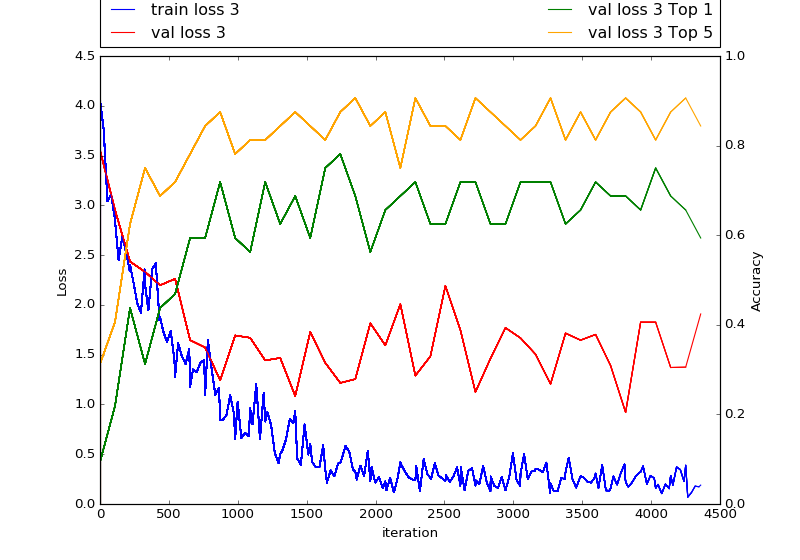


                0		'train loss3/loss3': 4.062 'val loss3/loss3': 3.555 
                		'loss3/top-1': 0.094 'loss3/top-5': 0.312

                109		'train loss3/loss3': 2.847 'val loss3/loss3': 2.953 
                		'loss3/top-1': 0.219 'loss3/top-5': 0.406

                218		'train loss3/loss3': 2.401 'val loss3/loss3': 2.435 
                		'loss3/top-1': 0.438 'loss3/top-5': 0.625

                327		'train loss3/loss3': 2.207 'val loss3/loss3': 2.331 
                		'loss3/top-1': 0.312 'loss3/top-5': 0.750

                436		'train loss3/loss3': 1.876 'val loss3/loss3': 2.197 
                		'loss3/top-1': 0.438 'loss3/top-5': 0.688

                545		'train loss3/loss3': 1.278 'val loss3/loss3': 2.262 
                		'loss3/top-1': 0.469 'loss3/top-5': 0.719

                654		'train loss3/loss3': 1.176 'val loss3/loss3': 1.646 
                		'loss3/top-1': 0.594 'loss3/top-5': 0.781

                763		'train loss3/loss3': 1.094 'val los

In [9]:
activities_solver_filename = activities_net_desc['solver']

activities_solver = caffe.get_solver(activities_solver_filename)
activities_solver.net.copy_from(googlenet_weights)

print 'Running solver for %d iterations...' % solver_data['num_iter']

solver_desc = ('finetuning', activities_solver)

init = time.clock()

# runs the solver
train_data, val_data, finetuning_weights = run_solvers(
    solver_data['num_iter'], 
    solver_desc, 
    solver_data['display_interval'], 
    solver_data['val_interval'])

end = time.clock() - init
print "Traning done in %2.f s" %(end)

# deleting stuff to save memory
del activities_solver, solver_desc


store_weights(finetuning_weights)
